<a href="https://colab.research.google.com/github/JorgeVitor30/logicomp-projeto/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Running All pip install necessary


In [297]:
!pip install python-sat
!pip install pysat


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: C:\Users\Jonh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: C:\Users\Jonh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Importing All functions and formulas

In [298]:
from formula import *
from functions import *

from pysat.solvers import Glucose3



## Inicitialization Solver

In [299]:
solver = Glucose3()

## Read file functions
Those functions read courses, slots and common inscription courses

In [300]:
def open_archive():
    with open("input.txt", "r") as archive:
        lines = archive.readlines()
    return lines

def get_all_courses():

    lines = open_archive()


    list_courses = []
    for line in lines:
        if line.startswith('# Minicursos'):
            continue
        if line.startswith('#'):
            break
        list_courses.append(line.split(' ')[1])

    qtd_courses = len(list_courses)

    minicourses = {}

    for x in range(0,qtd_courses):
        minicourses[x+1] = list_courses[x]

    return minicourses


def get_count_slots():
    lines = open_archive()

    list_line = []
        
    for line in lines:
        if line.startswith('# Minicursos'):
            continue

        list_line.append(line.split(' ')[2])
        
        if 'Slots' in line:
            num = line.split()
            slot = num[2]

    return slot
    

def get_time_pairs():
    lines = open_archive()

    list_courses = []
    
    found_pairs = False

    for line in lines:
        if found_pairs:
            minicourse1, minicourse2 = line.split(' ')[:2]
            
            list_courses.append((int(minicourse1), int(minicourse2)))
            
        elif line.startswith('# Pares de minicursos com inscrições em comum:'):
            found_pairs = True
   
    return list_courses 

## Conjunctive Normal Form (CNF) functions
To put any propositional logic formula in CNF, we need to follow three steps using equivalence:

Consider A, B and C any formulas of propositional logic
#### 1. Remove all implications: 
We can remove any implication formula by changing the formula by the equivalent formula:


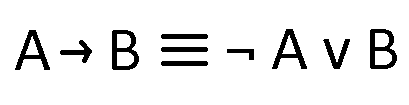


#### 2. Negation Normal Form: 
The negations in NNF are only beside logical variables. If an negation are directly in a clause, we use De Morgan law to "throw" the negation inside the clause.


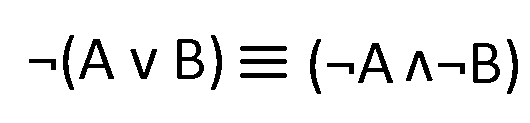


#### 3. Distributive: 
Sometimes whe found formulas with AND intern logical operator, which can't happen in CNF. CNF clauses are connected by AND operator and the literals inside the clauses are connected by OR operator. Knowing this, we use distributive to remove the AND operator as the intern logical operator.
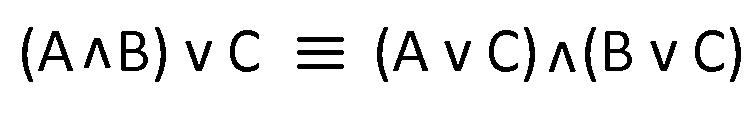

Based on Tiago Alves's videos.

In [301]:
def implication_free(formula):
    if (isinstance(formula, Implies) or isinstance(formula, Or) or isinstance(formula, And)):
        left = implication_free(formula.left)
        right = implication_free(formula.right)
        
        if (isinstance(formula, Implies)):
            return (Or(Not(left), right))
        
        if (isinstance(formula, Or)):
            return Or(left, right)
        
        if (isinstance(formula, And)):
            return And(left, right)
        
    if (isinstance(formula, Not)):
        inner = implication_free(formula.inner)
        return Not(inner)
    
    if (isinstance(formula, Atom)):
        return formula
    return formula


def negation_normal_form(formula):    
    if (isinstance(formula, Not) and isinstance(formula.inner, Not)):
        removed_double_negation_formula = formula.inner.inner
        return negation_normal_form(removed_double_negation_formula)
    
    if (isinstance(formula, Or)):
            return Or(negation_normal_form(formula.left), negation_normal_form(formula.right))
        
    if (isinstance(formula, And)):
            return And(negation_normal_form(formula.left), negation_normal_form(formula.right))
        
    if (isinstance(formula, Not)):
        inner_formula = formula.inner

        if (isinstance(inner_formula, Or)):
                return And(negation_normal_form(Not((inner_formula.left))), negation_normal_form(Not(inner_formula.right)))
            
        if (isinstance(inner_formula, And)):
                return Or(negation_normal_form(Not(inner_formula.left)), negation_normal_form(Not(inner_formula.right)))
    
    if (isinstance(formula, Atom) or (isinstance(formula, Not) and isinstance(formula.inner, Atom))):
        return formula
    
    return formula


def distributive(formula):
    if (isinstance(formula, And)):
        return And(distributive(formula.left), distributive(formula.right))
    
    if (isinstance(formula, Or)):
        left = distributive(formula.left)
        right = distributive(formula.right)
        if (isinstance(left, And)):
            return And(distributive(Or(left.left, right)), distributive(Or(left.right, right)))
        
        if (isinstance(right, And)):
            return And(distributive(Or(left, right.left)), distributive(Or(left, right.right)))
        
    if (isinstance(formula, Atom) or (isinstance(formula, Not) and isinstance(formula.inner, Atom))):
        return formula
    
    return formula


def cnf(formula):
    implication_free_formula = implication_free(formula)
    nnf_formula = negation_normal_form(implication_free_formula)
    cnf_formula = distributive(nnf_formula)

    return cnf_formula

## Restrictions functions
### These functions apply the three restrictions of the problem:
1. One course have to be in almost one slot (at_least_in_one_slot)

Example: Course 1 in almost one slot

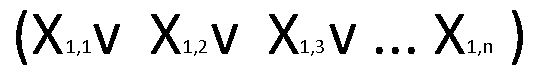

2. One course can't be in more than one slot (max_in_one_slot)

Consists in negate each combination of same course in different slots

Example: Course 1 in max of one slots, with 3 total slots

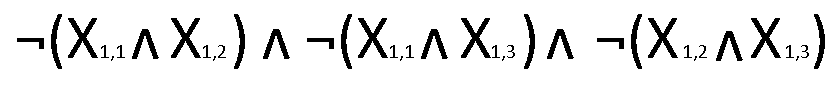

3. Two courses with common inscriptions can't be in the same slot (turn_common_inscriptions_pair_minicourses_to_propositional_logic)

Consists in negate each combination of common inscription courses in same slot

Example: Course 1 and 2 have common inscriptions, with 3 total slots

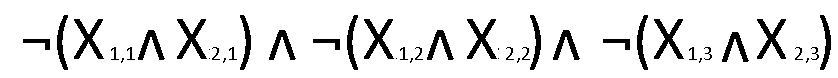

In [302]:
def turn_common_inscriptions_pair_minicourses_to_propositional_logic(cx, cy, slots):
    firstCourseInFirstSlot = Atom(f"x_{cx}_1")
    secondCourseInFirstSlot = Atom(f"x_{cy}_1")
    formula = Not(And(firstCourseInFirstSlot, secondCourseInFirstSlot))

    for slot in range(2, slots+1):
        formula = And(formula, Not(And(Atom(f"x_{cx}_{slot}"), Atom(f"x_{cy}_{slot}"))))
    

    return formula


def at_least_in_one_slot(cx, slots):
    firstCourseInFirstSlot = Atom(f"x_{cx}_1")
    formula = firstCourseInFirstSlot

    for slot in range(2, slots+1):
        formula = Or(formula, Atom(f"x_{cx}_{slot}"))

    return formula

def max_in_one_slot(cx, slots):

    for x in range(1, slots + 1):
        for y in range(x + 1, slots + 1):
            not_in_two_slots = Not(And(Atom(f"x_{cx}_{x}"),Atom(f"x_{cx}_{y}")))

            if x == 1 and y == 2:
                formula = not_in_two_slots

            else:
                formula = And(formula, Not(And(Atom(f"x_{cx}_{x}"),Atom(f"x_{cx}_{y}"))))

    return formula



## Adjusting our formulas to pySAT
To verify if our formulas are satisfative, we have to pass each literal as a id in pySAT IDPool. To turn it easy, we parse the CNF formula to clause form.

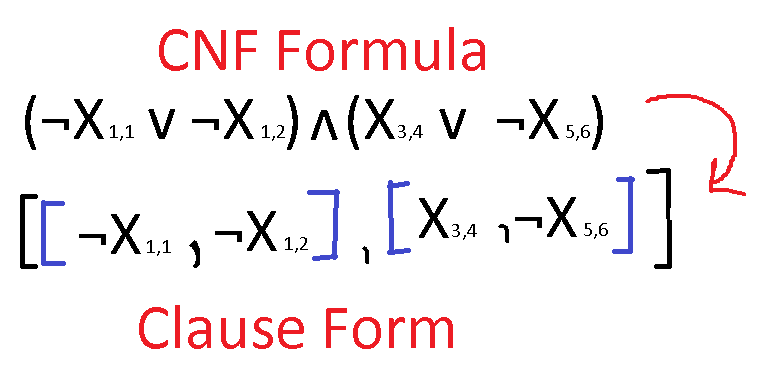

In [303]:
from pysat.formula import IDPool

def parse_cnf_to_clause_form(formula):
    string_formula = str(formula)
    string_formula_without_parentesis = string_formula.replace("(", "").replace(")", "")
    clauses =  string_formula_without_parentesis.split('\u2227')
    for x in range(0, len(clauses)):
        clauses[x] = clauses[x].strip().split(' \u2228 ')

    return clauses


def parse_clauses_to_id(clauses):
    var_pool = IDPool()
    id_list = []

    for x in range(0, len(clauses)):
        actualClause = []
        for y in range (0, len(clauses[x])):
            if (clauses[x][y][0] == "\u00ac"):
                actualClause.append(int(var_pool.id(clauses[x][y].replace("\u00ac", "")) * (-1)))
            else:
                actualClause.append(int(var_pool.id(clauses[x][y])))
        id_list.append(actualClause)

    return id_list
            

## Reading file to get slots, courses, and common inscriptions courses

In [304]:
slots = int(get_count_slots())
courses = get_all_courses()
print(courses)
## common_inscriptions_courses = get_time_pairs()
common_inscriptions_courses = [[1,2],[2,3],[2,4],[3,4]]

{1: 'HTML', 2: 'PHP', 3: 'MySQL', 4: 'Swift'}


## Applying all restrictions & parsing to CNF

In [305]:
for course_pair in common_inscriptions_courses:
    if course_pair == common_inscriptions_courses[0]:

        common_inscriptions_courses_restrictions = turn_common_inscriptions_pair_minicourses_to_propositional_logic(course_pair[0], course_pair[1], slots)
    else:
        common_inscriptions_courses_restrictions = And(common_inscriptions_courses_restrictions, turn_common_inscriptions_pair_minicourses_to_propositional_logic(course_pair[0], course_pair[1], slots))
    


for course_number in range(1, len(courses) + 1):
    if course_number == 1:
        at_least_in_one_slot_restrictions = at_least_in_one_slot(course_number, slots)
        max_in_one_slot_restrictions = max_in_one_slot(course_number, slots)
    else:
        at_least_in_one_slot_restrictions = And(at_least_in_one_slot_restrictions, at_least_in_one_slot(course_number, slots))
        max_in_one_slot_restrictions = And(max_in_one_slot_restrictions, max_in_one_slot(course_number, slots))


all_restrictions = And(And(max_in_one_slot_restrictions, at_least_in_one_slot_restrictions), common_inscriptions_courses_restrictions)
cnf_restrictions = cnf(all_restrictions)

## Parsing CNF formula to id

In [306]:
clause_form_restrictions =  parse_cnf_to_clause_form(cnf_restrictions)

id_clauses = parse_clauses_to_id(clause_form_restrictions)


clause_set = []
id_clause_set = []

for clause in clause_form_restrictions:
    for literal in clause:
        if literal not in clause_set:
            clause_set.append(literal)

for clause in id_clauses:
    for literal in clause:
        if literal not in id_clause_set:
            id_clause_set.append(literal)
        


## Verify Satisfatibility and getting Valoration

In [307]:
solver.append_formula(id_clauses)
isSatisfatible =  solver.solve()
if isSatisfatible:
    valoration =  solver.get_model()


    truly_course_variables = []

    for id in valoration:
        if id > 0:
            truly_course_variables.append(clause_set[id_clause_set.index(id)])

    for course_variable in truly_course_variables:
        course_number = int(course_variable[2])
        slot_number = int(course_variable[4])
        course_name = courses[course_number]

        print(f"O curso {course_name} ficará no slot de horário {slot_number}")
else:
    print("É impossível organizar os cursos com a quantidade de slots e restrições fornecidas.")


É impossível organizar os cursos com a quantidade de slots e restrições fornecidas.
